In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

# Enable inline plotting
%matplotlib inline

# Progress bar
from tqdm.auto import trange, tqdm

In [2]:
from spaceKLIP.psf import JWST_PSF
matplotlib.rcParams.update({'font.size': 8})

[   webbpsf:INFO] NIRCam aperture name updated to NRCA1_FULL


2023-09-24 21:14:15,724 - stpipe - INFO - NIRCam aperture name updated to NRCA1_FULL


[    stpipe:INFO] NIRCam aperture name updated to NRCA1_FULL
[   webbpsf:INFO] NIRISS SIAF aperture name updated to NIS_CEN


2023-09-24 21:14:15,745 - stpipe - INFO - NIRISS SIAF aperture name updated to NIS_CEN


[    stpipe:INFO] NIRISS SIAF aperture name updated to NIS_CEN
[   webbpsf:INFO] MIRI SIAF aperture name updated to MIRIM_FULL


2023-09-24 21:14:15,830 - stpipe - INFO - MIRI SIAF aperture name updated to MIRIM_FULL


[    stpipe:INFO] MIRI SIAF aperture name updated to MIRIM_FULL


In [56]:
psf_generator = JWST_PSF('NRCA5_MASKLWB_F335M', 'F335M', fov_pix=321, use_coeff=False)

[spaceKLIP.psf:INFO] Generating on-axis and off-axis PSFs...


Bar PSFs:   0%|          | 0/9 [00:00<?, ?it/s]

[spaceKLIP.psf:INFO]   Done.


In [58]:
data0 = np.zeros((320, 320))

apsiaf = psf_generator.inst_on.siaf_ap
xoff, yoff = (0,0)

yi, xi = np.indices(data0.shape)
xidl, yidl = apsiaf.sci_to_idl(xi + 1 - xoff, yi + 1 - yoff)
mask = psf_generator.inst_on.gen_mask_transmission_map((xidl, yidl), 'idl')

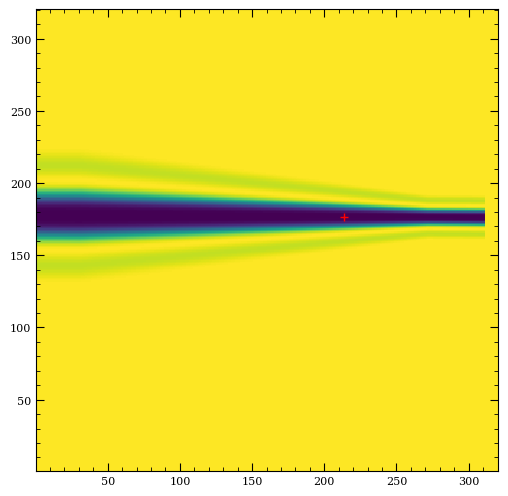

In [67]:
im = np.random.normal(size=(320,320))
plt.imshow(mask, extent=[0.5,320.5,0.5,320.5])
plt.plot(apsiaf.XSciRef, apsiaf.YSciRef, 'r+')

# plt.xlim([300,322])
# plt.ylim([300,322])

In [60]:
psf_off = psf_generator.gen_psf_idl((0, 8), quick=True)

In [61]:
psf_off2 = psf_generator.psf_off

In [62]:
psf_off2.sum() / psf_off.sum()

1.0000000000000004

In [63]:
psf_near = psf_generator.gen_psf_idl((0.1, 0.1), quick=True)

In [64]:
psf_generator.inst_on.gen_mask_transmission_map((0.1, 0.1), 'idl')

array([0.00327914])

In [65]:
psf_near.sum() / psf_off.sum()

0.0071148212446267515

In [30]:
from webbpsf_ext.image_manip import fourier_imshift
from webbpsf_ext.imreg_tools import crop_image

psf = crop_image(psf_generator.psf_off, 64)
psf_sh = fourier_imshift(psf, 0.5, 0)

In [31]:
from spaceKLIP.psf import recenter_jens
from webbpsf_ext.imreg_tools import recenter_psf

sh_jens = recenter_jens(psf_sh)
_, sh_jml = recenter_psf(psf_sh)

psf_jens = fourier_imshift(psf_sh, -sh_jens[0], -sh_jens[1])
psf_jml = fourier_imshift(psf_sh, -sh_jml[0], -sh_jml[1])

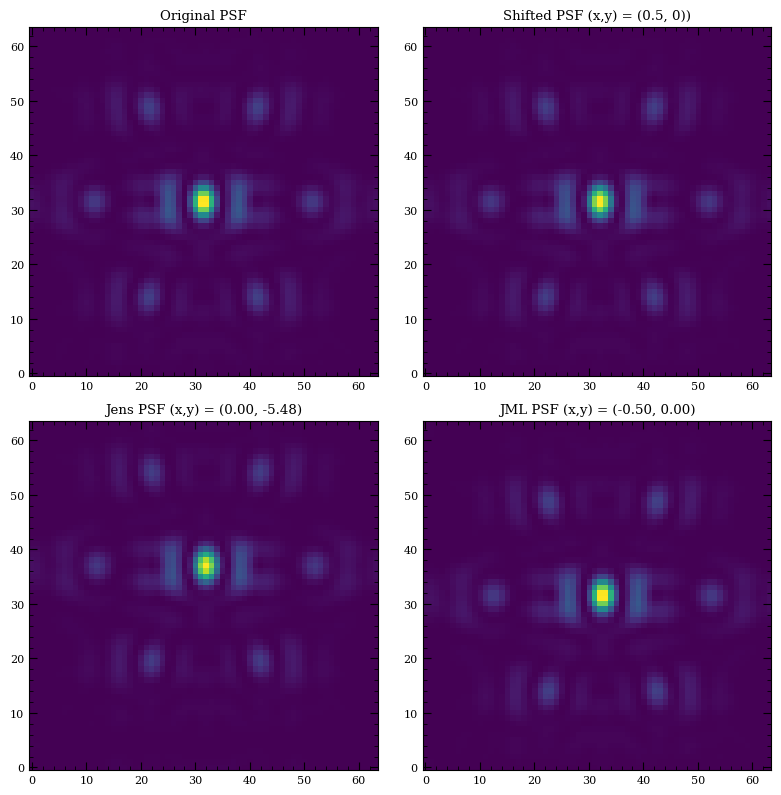

In [33]:
fig, axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.flatten()

axes[0].imshow(psf)
axes[0].set_title('Original PSF')

axes[1].imshow(psf_sh)
axes[1].set_title('Shifted PSF (x,y) = (0.5, 0))')

axes[2].imshow(psf_jens)
axes[2].set_title(f'Jens PSF (x,y) = ({sh_jens[0]:.2f}, {sh_jens[1]:.2f})')

axes[3].imshow(psf_jml)
axes[3].set_title(f'JML PSF (x,y) = ({sh_jml[0]:.2f}, {sh_jml[1]:.2f})')

fig.tight_layout()

In [4]:
psf_obj = JWST_PSF('NRCA5_MASK335R', 'F335M', fov_pix=321, use_coeff=True)

[spaceKLIP.psf:INFO] Generating on-axis and off-axis PSFs...
[spaceKLIP.psf:INFO]   Done.
Execution time: 0.01938772201538086 seconds


In [4]:
np.arange(318, 325)

array([318, 319, 320, 321, 322, 323, 324])

In [4]:
%time psf_quick = psf_obj.gen_psf_idl((1,0), quick=True, do_shift=True)
print(psf_quick.sum())

%time psf_slow = psf_obj.gen_psf_idl((1,0), quick=False, do_shift=True)
print(psf_slow.sum())

CPU times: user 49.4 ms, sys: 11.5 ms, total: 60.9 ms
Wall time: 59.9 ms
0.17898023472212504
CPU times: user 3.49 s, sys: 6.33 s, total: 9.82 s
Wall time: 1.11 s
0.1782626812257251


In [14]:
diff = psf_slow-psf_quick
diff.min(), diff.max()

(-2.9171214009022435e-09, 3.6646789301341288e-09)

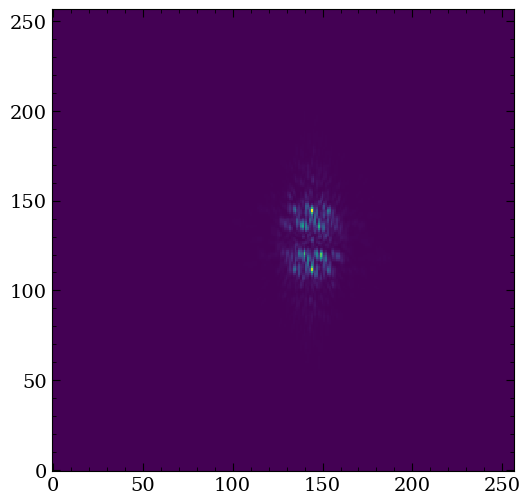

In [16]:
plt.imshow(psf_quick)